# Predicting Poetic Movements

## Modeling

### Using Naive Bayes, Decision Tree, Random Forest, and SVM

### NOTE: Currently working on revamping/organizing. Thank you for understanding :)

## Table of contents

1. [Introduction](#Introduction)
2. [The problem domain](#The-problem-domain)
3. [Required libraries](#Required-libraries)
4. [Step 1: Preparing the data](#Step-1:-Preparing-the-data)



## Introduction

[[go back to the top](#Predicting-Poetic-Movements)]

After [scraping](01_webscraping.ipynb) PoetryFoundation.org for genre-labeled poems and [cleaning](02_data_cleaning.ipynb), I will use natural language processing (NLP) techniques to analyze poetic structure across poetic genres and movements. 

Through text processing, exploratory data analysis, and feature engineering, I will look for insights into how poetic structure, word usage, lexical richness, and sentiment relate to the genre of a poem.

I will then create predictive models that classify poems into one of four umbrella movements: *Avant-Garde*, *Metropolitan*, *Modern*, or *Pre-1900*. This will help provide further insight and confirm my findings during EDA. *(NOTE: To skip to the modeling notebook, click [here](04_modeling.ipynb))*.

The ultimate goal is to create a recommendation system that compares poem similarities and recommends individual poems to users. *(NOTE: To skip to the recommendation system notebook, click [here](05_recommendation_system.ipynb))*.

## The problem domain

[[go back to the top](#Predicting-Poetic-Movements)]

Within written media, poetry is often regarded as enigmatic, frivolous, or too niche. As a result, poems (even by established poets) are often overlooked by larger publishers and literature-focused websites alike. (The anti-capitalist nature of poetry may play a role here as well). There are services for rating and recommending entire books (including poetry collections, to be fair) like GoodReads, Amazon, or Bookish, but to my knowledge, there aren't any sites or services that recommend poems on an individual level.

With this in mind, I wondered how poem recommendation may even work. One often finds a genre or two that they like and search that out, but there must be elements of poetry that transcend genre. If there are, machine learning seems like a perfect tool to use to find them. As a poet and writer, I am interested in creating something that will allow me to discover genres and movements that I may have previously ignored. I can do this by using poems I already know and enjoy to find similar poems from genres I may not know as well.

## Required libraries

[[go back to the top](#Predicting-Poetic-Movements)]

This notebook uses several Python packages that come standard with the Anaconda Python distribution. Libraries within this category that I'll be using are:

- **numpy**: Provides a fast numerical array structure and helper functions.
- **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
- **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
- **seaborn**: Advanced statistical plotting library.
- **scipy**: The essential statistical analysis package in Python.
- **collections**: A package with specialized and higher-performance data structures.
- **warnings**: A helpful package to ignore warnings that unnecessarily clutter the notebook.
- **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.

This notebook also uses some additional packages that you may have to install:

- **nltk**: The essential natural language processing package.
- **gensim**: A more specialized natural language processing package.
- **pickle**: Package to save a file as a byte stream.
- **gzip**: Package to compress/unpack files.

Finally, included within the repository, and necessary to run this workbook, is:
- **[functions](functions.py)**: Custom functions that I built for this project.

Required within the functions file are:
- **itertools**: An package aiding in advanced iteration techniques.
- **regex**: The essential string matching and capturing package.
- **string**: A package with string-specific operations and characters.
- **pronouncing**: A package utilizing the CMU Pronouncing Dictionary that can break language down by syllable, rhyme, and meter.
- **textblob**: A supplementary package to enhance the nltk package.

In [1]:
# custom functions for this project
from functions import *

# dataframe libraries
import pandas as pd
import numpy as np

# graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

# text processing
# from nltk import RegexpTokenizer
# from gensim import matutils, models
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse

# modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.svm import SVC

from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

# miscellany
import time
import gzip
import pickle

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore sklearn/tensorflow warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# increase column width of dataframe
pd.set_option('max_colwidth', 150)

Using TensorFlow backend.


# Step 1: Preparing the data

[[go back to the top](#Predicting-Poetic-Movements)]



#### 💾 Load DataFrame

In [2]:
# uncomment to load
with gzip.open('data/poetry_movements_df.pkl', 'rb') as hello:
    df = pickle.load(hello)

In [3]:
df.columns

Index(['poet', 'poem_url', 'title', 'poem_lines', 'poem_string', 'genre',
       'movement', 'clean_lines', 'num_lines', 'lines_titled', 'num_words',
       'avg_len_line', 'string_titled', 'sentiment_polarity_score',
       'sentiment_polarity', 'sentiment_subjectivity_score', 'num_end_rhymes',
       'end_rhyme_ratio', 'end_rhyme', 'avg_syllables_word',
       'lexical_richness', 'string_cleaned'],
      dtype='object')

In [5]:
# check out the class balance
df.movement.value_counts(normalize=True)

modern          0.288832
metropolitan    0.248665
pre_1900        0.240771
avant_garde     0.221732
Name: movement, dtype: float64

### Scatter matrix, to help limit features in later notebooks

In [10]:
cont_cols = [
    'num_lines', 'num_words', 'avg_len_line', 
    'sentiment_polarity_score', 'sentiment_subjectivity_score', 
    'num_end_rhymes', 'end_rhyme_ratio', 'avg_syllables_word', 
    'lexical_richness'
]

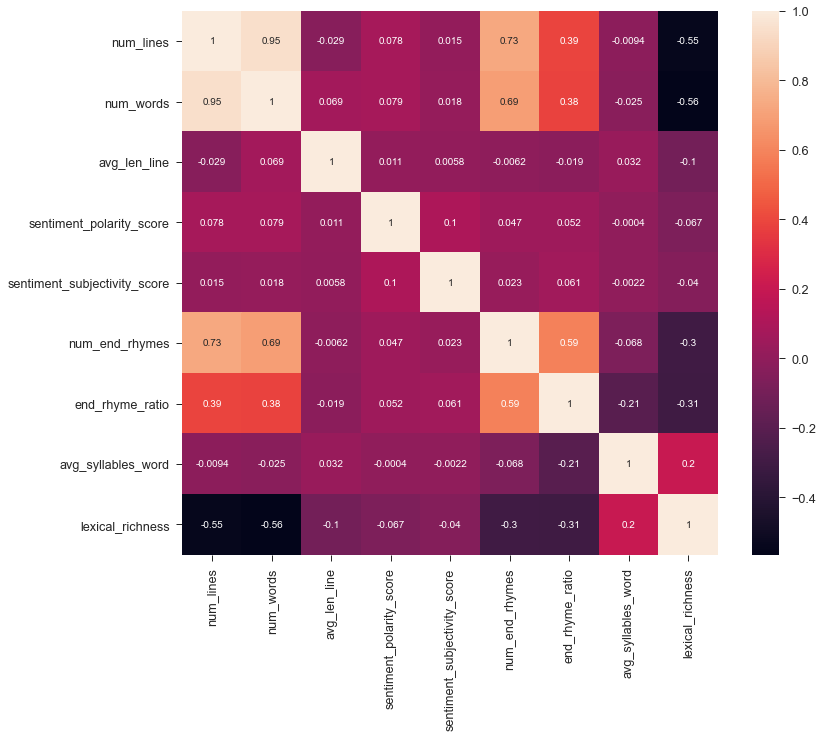

In [11]:
# plot correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(df[cont_cols].corr(), annot=True);

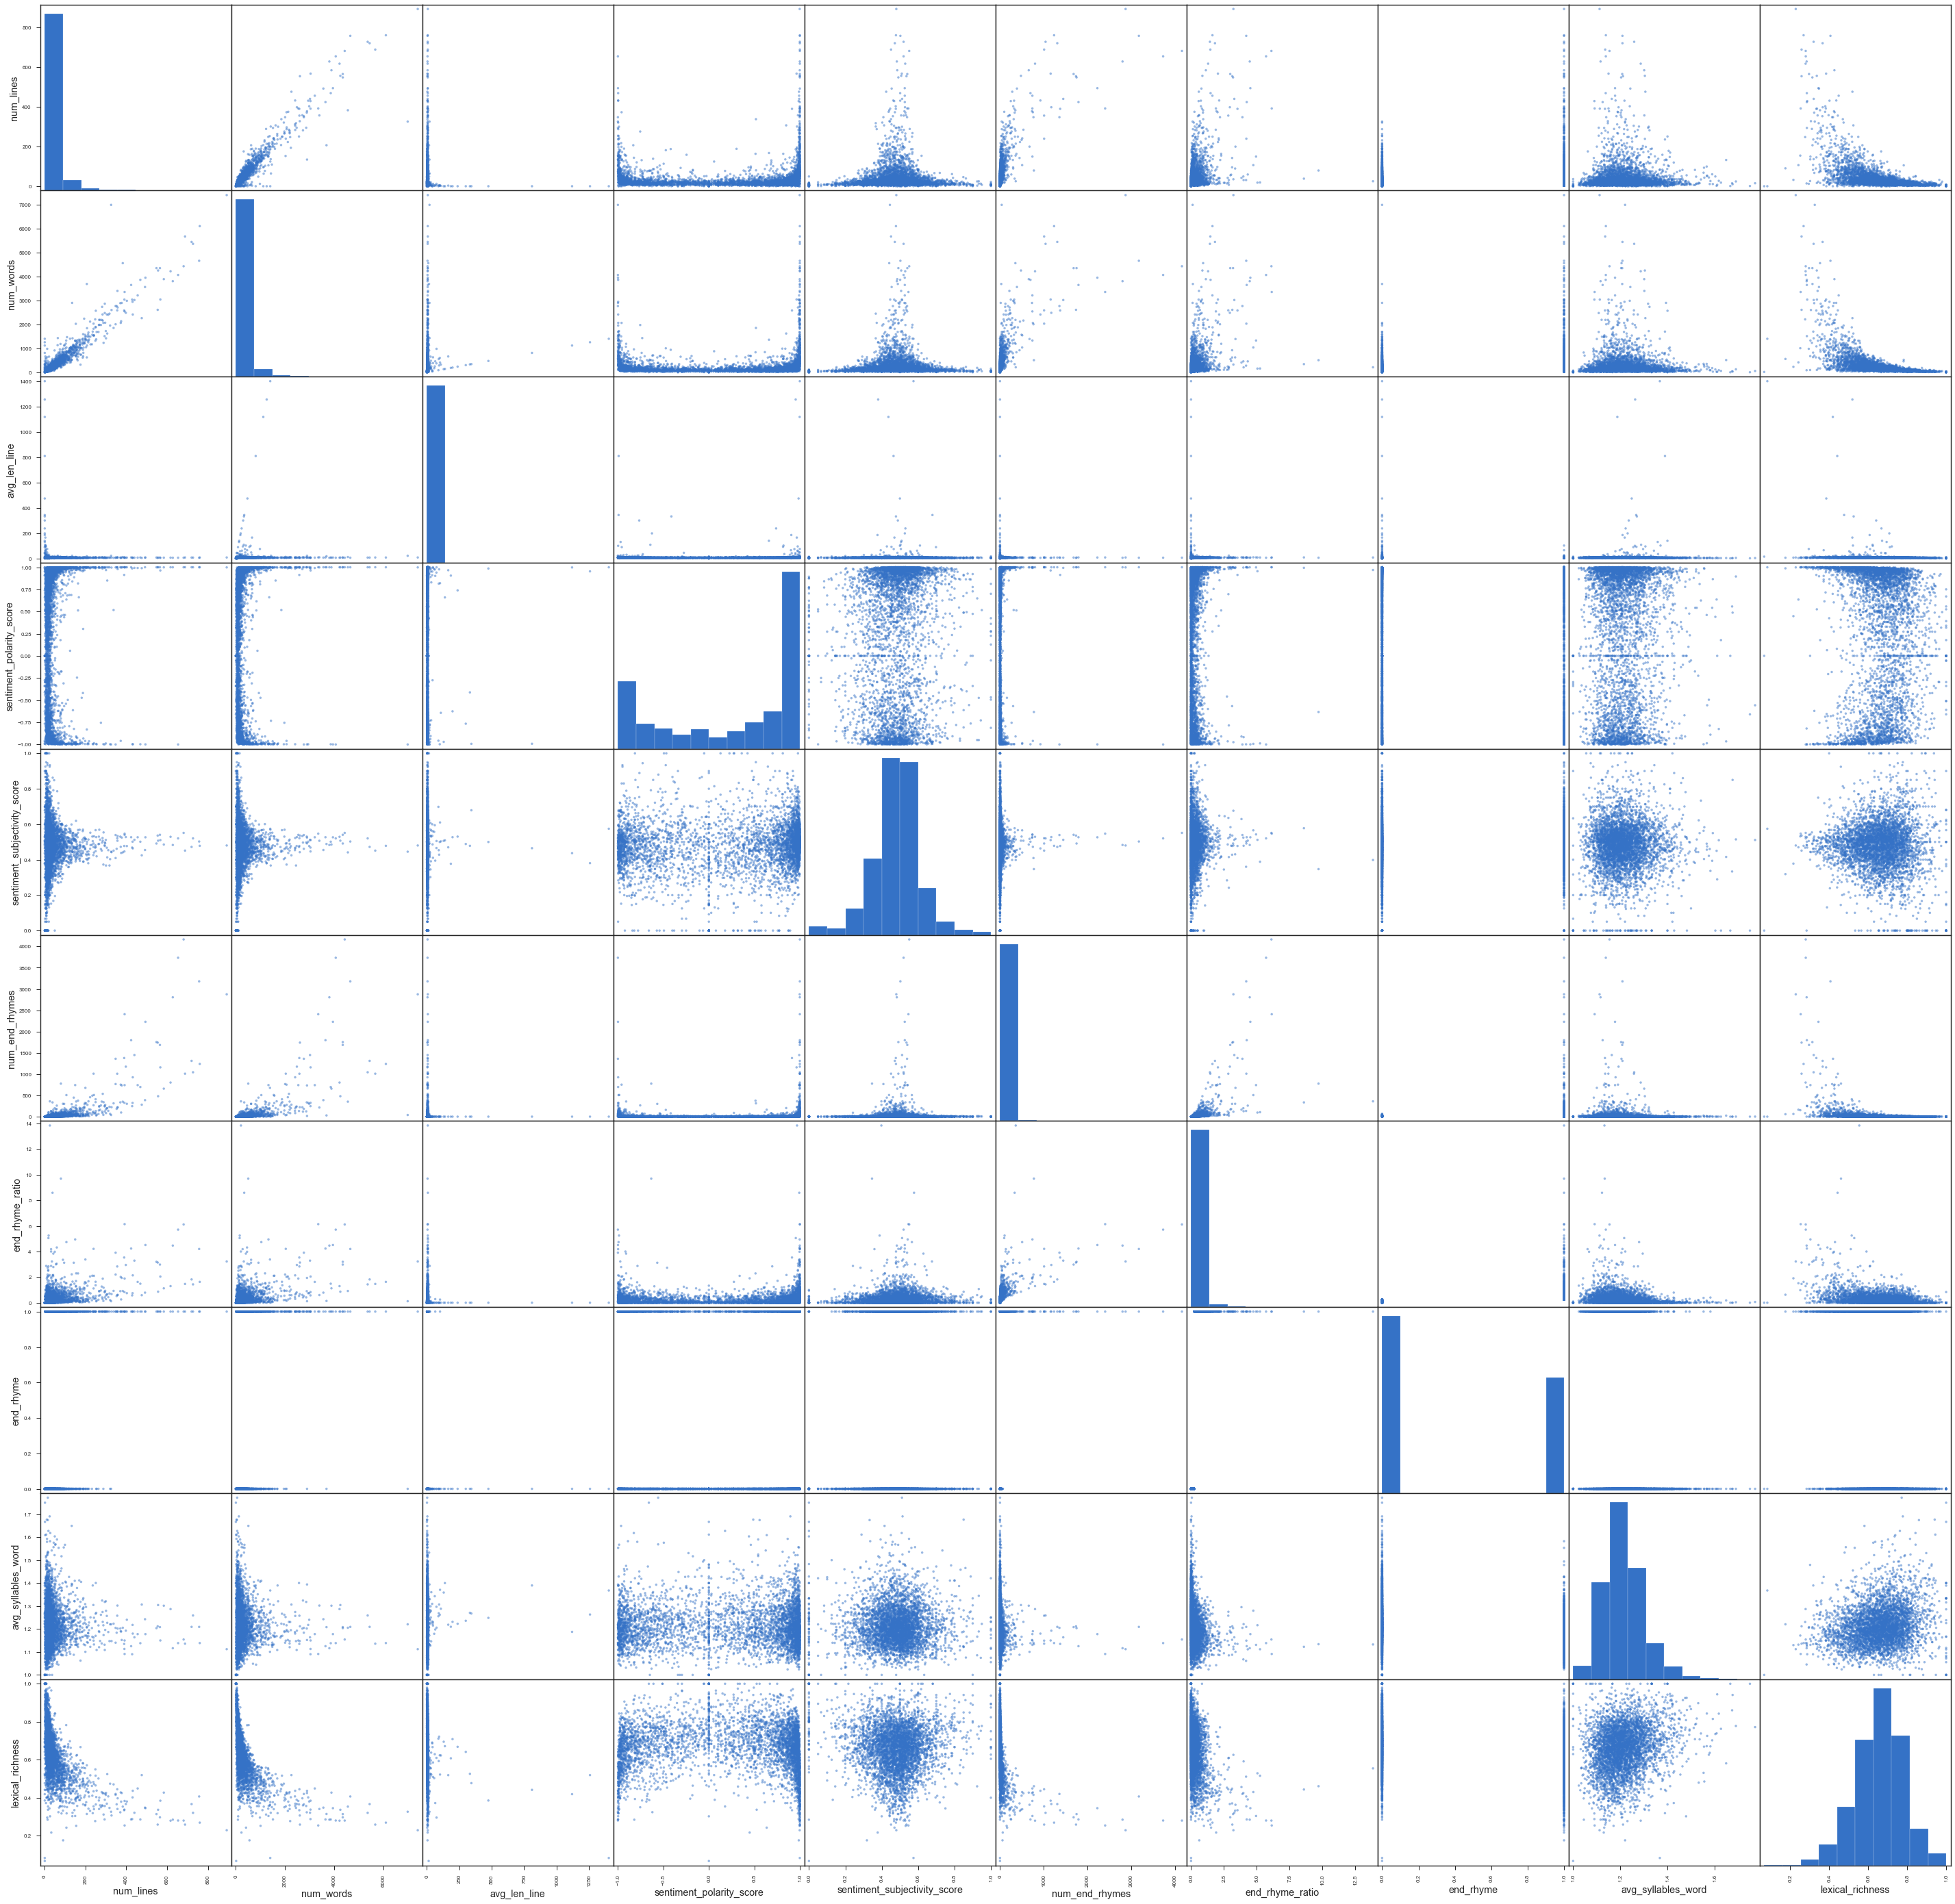

In [4]:
pd.plotting.scatter_matrix(
    df[['num_lines', 'num_words', 'avg_len_line', 
        'sentiment_polarity_score', 'sentiment_polarity', 
        'sentiment_subjectivity_score', 'num_end_rhymes', 
        'end_rhyme_ratio', 'end_rhyme', 'avg_syllables_word', 
        'lexical_richness']], 
    figsize=(50,50));

## Modeling Prep

### Removing outliers/capping values so they don't throw off the scaler in the next notebook.

#### Number of lines

In [ ]:
df_edit = df.copy()

In [ ]:
df_edit.num_lines.describe()

In [ ]:
df_edit[df_edit.num_lines < 90].num_lines

In [ ]:
df_edit[df_edit.num_lines < 90].num_lines.hist()

In [ ]:
df_edit['num_lines'] = np.where(df_edit.num_lines > 90, 90, df_edit.num_lines)

#### Number of words

In [ ]:
df.num_words.describe()

In [ ]:
df[df.num_words < 700].num_words

In [ ]:
df[df.num_words < 700].num_words.hist()

In [ ]:
df_edit['num_words'] = np.where(df_edit.num_words > 700, 700, df_edit.num_words)

#### Average words per line

In [ ]:
df[df.avg_len_line < 12].avg_len_line

In [ ]:
df[df.avg_len_line < 12].avg_len_line.hist()

In [ ]:
df_edit['avg_len_line'] = np.where(df_edit.avg_len_line > 12, 12, df_edit.avg_len_line)

#### Number of end rhymes

In [ ]:
df_edit.num_end_rhymes.describe()

In [ ]:
df_edit[df_edit.num_end_rhymes < 50].num_end_rhymes

In [ ]:
df_edit[df_edit.num_end_rhymes < 50].num_end_rhymes.hist()

In [ ]:
df_edit['num_end_rhymes'] = np.where(df_edit.num_end_rhymes > 50, 50, df_edit.num_end_rhymes)

#### End rhyme ratio

In [ ]:
df_edit.end_rhyme_ratio.describe()

In [ ]:
df_edit[df_edit.end_rhyme_ratio < 1].end_rhyme_ratio

In [ ]:
df_edit[df_edit.end_rhyme_ratio < 1].end_rhyme_ratio.hist()

In [ ]:
df_edit['end_rhyme_ratio'] = np.where(df_edit.end_rhyme_ratio > 50, 50, df_edit.end_rhyme_ratio)

## SAVE/LOAD -- EDITED Numerical features DataFrame

In [ ]:
# # uncomment to save
# with gzip.open('data/poetry_umbrella_genres_df_edit.pkl', 'wb') as goodbye:
#     pickle.dump(df_edit, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# # uncomment to load
# with gzip.open('data/poetry_umbrella_genres_df_edit.pkl', 'rb') as hello:
#     df = pickle.load(hello)

- **Classes are fairly balanced.**

### Create features and target dataframes

In [5]:
# assign a features dataframe
X = df[['num_lines', 'avg_len_line', 'sentiment_polarity_score', 'sentiment_subjectivity_score', 'num_end_rhymes', 
        'avg_syllables_word', 'string_titled', 'string_cleaned']]
# assign a target variable
y = df['genre']

### Train-Test Split

In [6]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3282, 8) (3282,)
(1094, 8) (1094,)


## Baseline model -- tf-idf vectors only

In [7]:
# instantiate the vectorizer
vectorizer = TfidfVectorizer()

# fit to training data's string_cleaned column and transform train and test sets
X_train_vec_matrix = vectorizer.fit_transform(X_train.string_cleaned)
X_test_vec_matrix = vectorizer.transform(X_test.string_cleaned)

In [8]:
# turn our tf-idf vectors into a dataframe so we can better view feature importances
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec_matrix, columns=vectorizer.get_feature_names())
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec_matrix, columns=vectorizer.get_feature_names())

In [9]:
%%time

# instantiate the naive bayes classifier
bnb_baseline_vec = BernoulliNB()

# fit it to our training set
bnb_baseline_vec.fit(X_train_vec, y_train)

CPU times: user 4.17 s, sys: 543 ms, total: 4.71 s
Wall time: 4.32 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [10]:
%%time

# predict the new document from the testing dataset
y_train_preds_vec = bnb_baseline_vec.predict(X_train_vec)
y_test_preds_vec = bnb_baseline_vec.predict(X_test_vec)

# print out accuracy and f1 scores for train set
bnb_baseline_vec_acc_train = accuracy_score(y_train, y_train_preds_vec)
bnb_baseline_vec_f1_train = f1_score(y_train, y_train_preds_vec, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {bnb_baseline_vec_acc_train}')
print(f'F1 score: {bnb_baseline_vec_f1_train}')

# print out accuracy and f1 scores for test set
bnb_baseline_vec_acc_test = accuracy_score(y_test, y_test_preds_vec)
bnb_baseline_vec_f1_test = f1_score(y_test, y_test_preds_vec, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {bnb_baseline_vec_acc_test}')
print(f'F1 score: {bnb_baseline_vec_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report
print(classification_report(y_test, y_test_preds_vec, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_vec))

-----TRAIN-----
Accuracy: 0.6066422912858014
F1 score: 0.6087765944613979

-----TEST-----
Accuracy: 0.4670932358318099
F1 score: 0.4253300995343577

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.61      0.08      0.15       241
 avant_garde       0.66      0.34      0.45       273
      modern       0.37      0.92      0.53       320
    pre_1900       0.77      0.41      0.53       260

    accuracy                           0.47      1094
   macro avg       0.60      0.44      0.41      1094
weighted avg       0.59      0.47      0.43      1094


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[ 20  33 179   9]
 [ 12  92 160   9]
 [  1  12 293  14]
 [  0   3 151 106]]
CPU times: user 6.43 s, sys: 774 ms, total: 7.21 s
Wall time: 5.98 s


- **Not too bad for a baseline. Certainly better than just predicting 'modern', which would give you a 29% accuracy.**
- **That said, it is indeed overpredicting on 'modern'.**

### Feature importances

- **Code modified from: https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes**

In [12]:
# assign the top 10 feature importances for each class
metro_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[:, 0].argsort()
modern_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[1, :].argsort()
avant_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[2, :].argsort()
pre1900_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[3, :].argsort()

In [13]:
# match them up with the proper label
print(np.take(X_train_vec.columns, metro_class_prob_sorted[:10]))
print(np.take(X_train_vec.columns, modern_class_prob_sorted[:10]))
print(np.take(X_train_vec.columns, avant_class_prob_sorted[:10]))
print(np.take(X_train_vec.columns, pre1900_class_prob_sorted[:10]))

Index(['aaaall', 'aaron', 'aalto', 'aaa'], dtype='object')
Index(['aaa', 'migratorious', 'milan', 'milder', 'mildness', 'miletus',
       'milholland', 'militarisme', 'milked', 'milkmaid'],
      dtype='object')
Index(['zwim', 'hoper', 'hopped', 'shipwright', 'hopscotch', 'horace',
       'horatian', 'shipwreck', 'horeb', 'shipwrack'],
      dtype='object')
Index(['aaa', 'grievings', 'rouchled', 'rotunda', 'rottenness', 'grig',
       'rotor', 'grille', 'roto', 'grimace'],
      dtype='object')


## Baseline model -- vectors + numerical data

- **Create dataframe.**

In [16]:
# separate out our numerical data
X_train_nums = X_train.drop(columns=['string_titled', 'string_cleaned'])
X_test_nums = X_test.drop(columns=['string_titled', 'string_cleaned'])

- **Scale and combine.**

In [17]:
# instantiate our scaler
scaler = MinMaxScaler()

# scale our numerical data
X_train_scaled = scaler.fit_transform(X_train_nums)
X_test_scaled = scaler.transform(X_test_nums)

# turn the arrays into dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_nums.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_nums.columns)

In [19]:
# combine the numerical and vector dataframes for both train and test sets
X_train_combo = pd.concat([X_train_scaled_df, X_train_vec], axis=1)
X_test_combo = pd.concat([X_test_scaled_df, X_test_vec], axis=1)

- **Model.**

In [20]:
%%time

# instantiate the naive bayes classifier
bnb_baseline_combo = BernoulliNB()

# fit it to our training set
bnb_baseline_combo.fit(X_train_combo, y_train)

CPU times: user 9.04 s, sys: 1.6 s, total: 10.6 s
Wall time: 10.3 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [21]:
%%time

# predict the new document from the testing dataset
y_train_preds_combo = bnb_baseline_combo.predict(X_train_combo)
y_test_preds_combo = bnb_baseline_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
bnb_baseline_combo_acc_train = accuracy_score(y_train, y_train_preds_combo)
bnb_baseline_combo_f1_train = f1_score(y_train, y_train_preds_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {bnb_baseline_combo_acc_train}')
print(f'F1 score: {bnb_baseline_combo_f1_train}')

# print out accuracy and f1 scores for test set
bnb_baseline_combo_acc_test = accuracy_score(y_test, y_test_preds_combo)
bnb_baseline_combo_f1_test = f1_score(y_test, y_test_preds_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {bnb_baseline_combo_acc_test}')
print(f'F1 score: {bnb_baseline_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report
print(classification_report(y_test, y_test_preds_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_combo))

-----TRAIN-----
Accuracy: 0.6096892138939671
F1 score: 0.612164783557265

-----TEST-----
Accuracy: 0.4670932358318099
F1 score: 0.4262879661539977

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.61      0.08      0.15       241
 avant_garde       0.66      0.34      0.45       273
      modern       0.37      0.91      0.53       320
    pre_1900       0.77      0.41      0.53       260

    accuracy                           0.47      1094
   macro avg       0.60      0.44      0.41      1094
weighted avg       0.59      0.47      0.43      1094


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[ 20  34 179   8]
 [ 11  94 159   9]
 [  2  12 291  15]
 [  0   3 151 106]]
CPU times: user 12.8 s, sys: 2.18 s, total: 14.9 s
Wall time: 13.7 s


- **Practically the same result.**

### Feature importances

In [79]:
# assign the top 10 feature importances for each class
metro_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[:, 0].argsort()
modern_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[1, :].argsort()
avant_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[2, :].argsort()
pre1900_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[3, :].argsort()

In [80]:
# match them up with the proper label
print(np.take(X_train_combo.columns, metro_class_prob_sorted[:10]))
print(np.take(X_train_combo.columns, modern_class_prob_sorted[:10]))
print(np.take(X_train_combo.columns, avant_class_prob_sorted[:10]))
print(np.take(X_train_combo.columns, pre1900_class_prob_sorted[:10]))

Index(['avg_len_line', 'sentiment_subjectivity_score',
       'sentiment_polarity_score', 'num_lines'],
      dtype='object')
Index(['num_lines', 'mightier', 'migliore', 'migrant', 'mike', 'mildew',
       'mildly', 'mile', 'milieu', 'militant'],
      dtype='object')
Index(['zunbrowned', 'hop', 'hope', 'shipboard', 'hopefully', 'hopeless',
       'hopelessly', 'ship', 'hopped', 'shiny'],
      dtype='object')
Index(['num_lines', 'griddlecake', 'rotha', 'rote', 'rotator', 'grieve',
       'rotate', 'grievings', 'rot', 'griffin'],
      dtype='object')


- **Some engineered features made it into this one.**

## Decision Tree -- tf-idf vectors only

- **I'll first take a quick look at cross validation scores.**

In [22]:
# instantiate the decision tree classifier
tree_vec = DecisionTreeClassifier()

# fit it to our training set and evaluate
cross_val_score(tree_vec, X_train_vec, y_train, cv=10, n_jobs=-1)

array([0.40425532, 0.40729483, 0.39329268, 0.39939024, 0.3902439 ,
       0.39329268, 0.41158537, 0.40243902, 0.42378049, 0.42682927])

- **Naive Bayes performs better.**

## Decision Tree -- vectors and numerical data

- **Look at cross validation scores.**

In [23]:
# instantiate the decision tree classifier
tree_combo = DecisionTreeClassifier()

# fit it to our training set and evaluate
cross_val_score(tree_combo, X_train_combo, y_train, cv=10, n_jobs=-1)

array([0.54103343, 0.48632219, 0.50609756, 0.45121951, 0.49085366,
       0.48780488, 0.50914634, 0.49695122, 0.49085366, 0.45731707])

- **A notable improvement, so I'll fit a model.**

In [24]:
%%time

# instantiate the model
tree_combo = DecisionTreeClassifier(random_state=1)

# fit to the training set
tree_combo.fit(X_train_combo, y_train)

CPU times: user 9.34 s, sys: 1.16 s, total: 10.5 s
Wall time: 10.5 s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [25]:
%%time

# predict class for the train and test sets
y_train_preds_tree_combo = tree_combo.predict(X_train_combo)
y_test_preds_tree_combo = tree_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
tree_combo_acc_train = accuracy_score(y_train, y_train_preds_tree_combo)
tree_combo_f1_train = f1_score(y_train, y_train_preds_tree_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {tree_combo_acc_train}')
print(f'F1 score: {tree_combo_f1_train}')

# print out accuracy and f1 scores for test set
tree_combo_acc_test = accuracy_score(y_test, y_test_preds_tree_combo)
tree_combo_f1_test = f1_score(y_test, y_test_preds_tree_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {tree_combo_acc_test}')
print(f'F1 score: {tree_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_tree_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_tree_combo))

-----TRAIN-----
Accuracy: 0.9993906154783668
F1 score: 0.9993903971862134

-----TEST-----
Accuracy: 0.4716636197440585
F1 score: 0.47004389709255623

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.48      0.46      0.47       241
 avant_garde       0.42      0.36      0.39       273
      modern       0.41      0.45      0.43       320
    pre_1900       0.58      0.62      0.60       260

    accuracy                           0.47      1094
   macro avg       0.47      0.47      0.47      1094
weighted avg       0.47      0.47      0.47      1094


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[112  59  63   7]
 [ 51  99  86  37]
 [ 55  50 145  70]
 [ 14  28  58 160]]
CPU times: user 7.7 s, sys: 1.53 s, total: 9.23 s
Wall time: 9.23 s


- **This is definitely better than our Naive Bayes model.**
    - **It predicts 'modern' a lot less.**
    - **Predictions seem fairly evenly spread.**
    - **Has trouble predicting avant-garde.**
    
### Feature importances

In [26]:
# create a dictionary
tree_features = dict(zip(X_train_combo.columns, tree_combo.feature_importances_))

# sort dictionary
tree_features = dict(sorted(tree_features.items(), key=lambda x: x[1], reverse=True)[:10])
tree_features

{'num_end_rhymes': 0.11007585654210111,
 'avg_len_line': 0.06060389285626467,
 'avg_syllables_word': 0.05830843115964017,
 'num_lines': 0.05269643035199075,
 'sentiment_polarity_score': 0.02258363492583386,
 'sentiment_subjectivity_score': 0.020310951818931028,
 'get': 0.014781807450453481,
 'light': 0.00892308241672876,
 'know': 0.007713988035427452,
 'little': 0.0070537491209945935}

- **Mostly engineered features on top.**

## Random Forest -- tf-idf vectors only

- **First, I'll take a quick look at cross validation scores.**

In [27]:
# instantiate the random forest classifier
forest_vec = RandomForestClassifier()

# fit it to our training set and evaluate
cross_val_score(forest_vec, X_train_vec, y_train, cv=10, n_jobs=-1)

array([0.56838906, 0.56534954, 0.55792683, 0.5152439 , 0.56707317,
       0.58536585, 0.57012195, 0.55182927, 0.55792683, 0.57926829])

- **Compare that to vectors plus numerical data.**

## Random Forest -- vectors and numerical data

- **Take a quick look at cross validation scores.**

In [28]:
# instantiate the random forest classifier
forest_combo = RandomForestClassifier()

# fit it to our training set and evaluate
cross_val_score(forest_combo, X_train_combo, y_train, cv=10, n_jobs=-1)

array([0.58054711, 0.63221884, 0.64634146, 0.58536585, 0.62804878,
       0.59146341, 0.59146341, 0.6097561 , 0.58841463, 0.62195122])

- **Including engineered features seems more promising, so I'll move ahead with this one.**

In [29]:
%%time

# instantiate the model
forest_combo = RandomForestClassifier(random_state=1)

# fit to the training set
forest_combo.fit(X_train_combo, y_train)

CPU times: user 19.8 s, sys: 1.18 s, total: 21 s
Wall time: 21 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [30]:
%%time

# predict class for the train and test sets
y_train_preds_forest_combo = forest_combo.predict(X_train_combo)
y_test_preds_forest_combo = forest_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
forest_combo_acc_train = accuracy_score(y_train, y_train_preds_forest_combo)
forest_combo_f1_train = f1_score(y_train, y_train_preds_forest_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {forest_combo_acc_train}')
print(f'F1 score: {forest_combo_f1_train}')

# print out accuracy and f1 scores for test set
forest_combo_acc_test = accuracy_score(y_test, y_test_preds_forest_combo)
forest_combo_f1_test = f1_score(y_test, y_test_preds_forest_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {forest_combo_acc_test}')
print(f'F1 score: {forest_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_forest_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_forest_combo))

-----TRAIN-----
Accuracy: 0.9993906154783668
F1 score: 0.9993903971862134

-----TEST-----
Accuracy: 0.6261425959780622
F1 score: 0.6213792967901269

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.68      0.46      0.55       241
 avant_garde       0.62      0.52      0.56       273
      modern       0.54      0.73      0.62       320
    pre_1900       0.73      0.77      0.75       260

    accuracy                           0.63      1094
   macro avg       0.64      0.62      0.62      1094
weighted avg       0.64      0.63      0.62      1094


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[110  59  58  14]
 [ 32 141  84  16]
 [ 19  24 233  44]
 [  0   3  56 201]]
CPU times: user 7.87 s, sys: 1.5 s, total: 9.37 s
Wall time: 9.38 s


- **Good results! So I'll look at a confusion matrix visualization.**

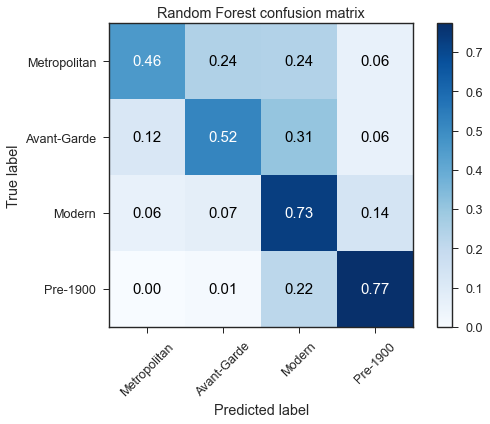

In [71]:
cm = confusion_matrix(y_test, y_test_preds_forest_combo)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

plt.figure(figsize=(8,6))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Random Forest confusion matrix',
                          cmap=plt.cm.Blues);

- **Big strides made on all categories here.**
- **Looks like some improvement could be made for avant-garde and metropolitan.**

### Feature importances

In [31]:
# create a dictionary
forest_features = dict(zip(X_train_combo.columns, forest_combo.feature_importances_))

# sort dictionary
forest_features = dict(sorted(forest_features.items(), key=lambda x: x[1], reverse=True)[:10])
forest_features

{'num_end_rhymes': 0.020076914328688845,
 'avg_len_line': 0.016599447912066877,
 'avg_syllables_word': 0.010609575975566466,
 'num_lines': 0.008350060082588609,
 'sentiment_polarity_score': 0.008100964810189928,
 'sentiment_subjectivity_score': 0.006233650462750479,
 'heart': 0.0035447417431501284,
 'get': 0.0032271297790378356,
 'day': 0.0031789311325537114,
 'sweet': 0.0030092352589805044}

- **Lots of engineered features here, and some surprise words.**
- **'Heart' appeared to be mostly within pre-1900 poetry, so that probably explains it's importance.**

## SVM Model - tf-idf vectors only

In [36]:
%%time

# instantiate the model
svm_vec = SVC(kernel='linear')

# fit to the training set
svm_vec.fit(X_train_vec, y_train)

CPU times: user 11min 23s, sys: 4.31 s, total: 11min 27s
Wall time: 11min 33s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [37]:
%%time

# predict class for the train and test sets
y_train_preds_svm_vec = svm_vec.predict(X_train_vec)
y_test_preds_svm_vec = svm_vec.predict(X_test_vec)

# print out accuracy and f1 scores for train set
svm_vec_acc_train = accuracy_score(y_train, y_train_preds_svm_vec)
svm_vec_f1_train = f1_score(y_train, y_train_preds_svm_vec, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_vec_acc_train}')
print(f'F1 score: {svm_vec_f1_train}')

# print out accuracy and f1 scores for test set
svm_vec_acc_test = accuracy_score(y_test, y_test_preds_svm_vec)
svm_vec_f1_test = f1_score(y_test, y_test_preds_svm_vec, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_vec_acc_test}')
print(f'F1 score: {svm_vec_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_vec, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_vec))

-----TRAIN-----
Accuracy: 0.9686166971358927
F1 score: 0.9685752094288665

-----TEST-----
Accuracy: 0.6261425959780622
F1 score: 0.6247558000810909

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.54      0.44      0.48       241
 avant_garde       0.58      0.61      0.60       273
      modern       0.57      0.67      0.62       320
    pre_1900       0.82      0.77      0.80       260

    accuracy                           0.63      1094
   macro avg       0.63      0.62      0.62      1094
weighted avg       0.63      0.63      0.62      1094


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[105  68  62   6]
 [ 41 167  55  10]
 [ 38  42 213  27]
 [  9   9  42 200]]
CPU times: user 9min 49s, sys: 2.07 s, total: 9min 51s
Wall time: 9min 53s


### Feature importances
- **Code credit: 'https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn'**

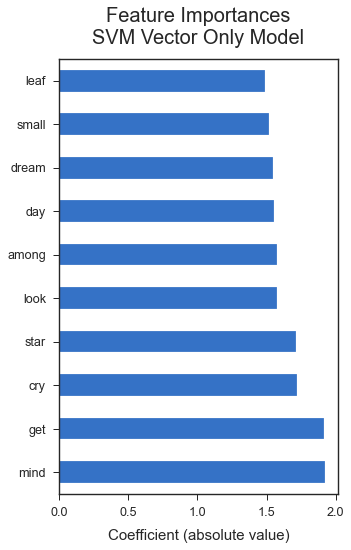

In [85]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Vector Only Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_vec.coef_[0]), index=X_train_vec.columns).nlargest(10).plot(kind='barh');

- **Quite a bump! very overfit, but I'll see if it works any better with our combo dataframes.**

## SVM - vectors + numerical data

In [38]:
%%time

# instantiate the model
svm_combo = SVC(kernel='linear')

# fit to the training set
svm_combo.fit(X_train_combo, y_train)

CPU times: user 9min 39s, sys: 2.77 s, total: 9min 42s
Wall time: 9min 43s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [39]:
%%time

# predict class for the train and test sets
y_train_preds_svm_combo = svm_combo.predict(X_train_combo)
y_test_preds_svm_combo = svm_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
svm_combo_acc_train = accuracy_score(y_train, y_train_preds_svm_combo)
svm_combo_f1_train = f1_score(y_train, y_train_preds_svm_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_combo_acc_train}')
print(f'F1 score: {svm_combo_f1_train}')

# print out accuracy and f1 scores for test set
svm_combo_acc_test = accuracy_score(y_test, y_test_preds_svm_combo)
svm_combo_f1_test = f1_score(y_test, y_test_preds_svm_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_combo_acc_test}')
print(f'F1 score: {svm_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_combo))

-----TRAIN-----
Accuracy: 0.9573430834856794
F1 score: 0.9572124926829236

-----TEST-----
Accuracy: 0.6755027422303473
F1 score: 0.6752703596917183

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.68      0.59      0.63       241
 avant_garde       0.63      0.63      0.63       273
      modern       0.61      0.66      0.63       320
    pre_1900       0.81      0.82      0.81       260

    accuracy                           0.68      1094
   macro avg       0.68      0.68      0.68      1094
weighted avg       0.68      0.68      0.68      1094


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[142  53  42   4]
 [ 29 173  60  11]
 [ 30  43 212  35]
 [  9   5  34 212]]
CPU times: user 10min 15s, sys: 2.9 s, total: 10min 18s
Wall time: 10min 19s


### Confusion matrix visualization

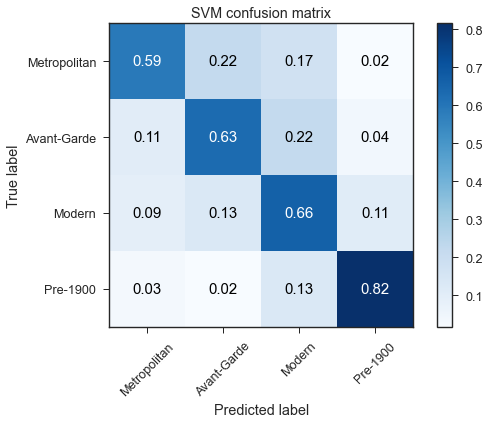

In [69]:
cm = confusion_matrix(y_test, y_test_preds_svm_combo)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

plt.figure(figsize=(8,6))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

- **Still overfit but nearly a 10% increase in the test predictions!**

### Feature importances

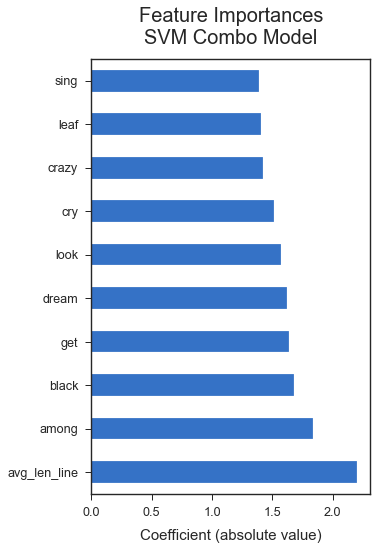

In [86]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_combo.coef_[0]), index=X_train_combo.columns).nlargest(10).plot(kind='barh');

- **Mostly surprising words, other than maybe 'get', which was a top 5 frequent word.**
- **Nice to see an engineered feature in the top spot.**

### Changing C value and class weight.

In [40]:
%%time

# instantiate the model
svm_combo2 = SVC(C=2, kernel='linear', class_weight='balanced')

# fit to the training set
svm_combo2.fit(X_train_combo, y_train)

CPU times: user 10min 53s, sys: 2.79 s, total: 10min 56s
Wall time: 10min 57s


SVC(C=2, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [41]:
%%time

# predict class for the train and test sets
y_train_preds_svm_combo2 = svm_combo2.predict(X_train_combo)
y_test_preds_svm_combo2 = svm_combo2.predict(X_test_combo)

# print out accuracy and f1 scores for train set
svm_combo_acc_train2 = accuracy_score(y_train, y_train_preds_svm_combo2)
svm_combo_f1_train2 = f1_score(y_train, y_train_preds_svm_combo2, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_combo_acc_train2}')
print(f'F1 score: {svm_combo_f1_train2}')

# print out accuracy and f1 scores for test set
svm_combo_acc_test2 = accuracy_score(y_test, y_test_preds_svm_combo2)
svm_combo_f1_test2 = f1_score(y_test, y_test_preds_svm_combo2, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_combo_acc_test2}')
print(f'F1 score: {svm_combo_f1_test2}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_combo2, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_combo2))

-----TRAIN-----
Accuracy: 0.9951249238269348
F1 score: 0.9951215811379879

-----TEST-----
Accuracy: 0.6782449725776966
F1 score: 0.6782315773457501

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.63      0.60      0.62       241
 avant_garde       0.62      0.65      0.64       273
      modern       0.64      0.64      0.64       320
    pre_1900       0.83      0.83      0.83       260

    accuracy                           0.68      1094
   macro avg       0.68      0.68      0.68      1094
weighted avg       0.68      0.68      0.68      1094


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[145  52  41   3]
 [ 38 177  47  11]
 [ 39  46 205  30]
 [  8   9  28 215]]
CPU times: user 10min 12s, sys: 2.85 s, total: 10min 15s
Wall time: 10min 16s


### Confusion matrix visualization

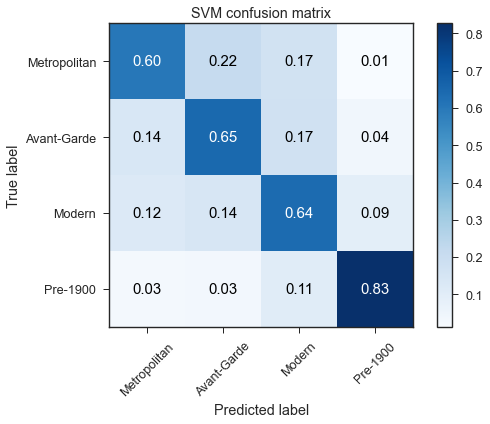

In [90]:
cm = confusion_matrix(y_test, y_test_preds_svm_combo2)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

plt.figure(figsize=(8,6))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

### Feature importances

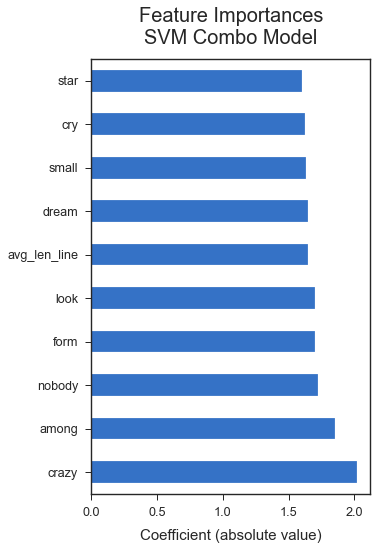

In [87]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_combo2.coef_[0]), index=X_train_combo.columns).nlargest(10).plot(kind='barh');

- **The number of words per line dropped down, but still in the top ten.**

# Modeling conclusions
- **Form/structure is important for prediction (especially Random Forest models).**
    - **Further exploration desired:**
        - **Other types of rhyme**
        - **Use of line breaks, tabs, and spacing**
        - **Topic modeling**
- **SVM relies mostly on vocabulary.**
    - **Further exploration desired:**
        - **Word embeddings (self-trained and pre-trained)**
        - **POS tagging**
- **SVM is the best model!**